In [26]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import LearningRateScheduler

RANDOM_SEED = 42

In [27]:
csv_file = 'keypoints\\keypointB_3D_augmented.csv'
model_save_path = 'model\\customModel\\modelB\\ASLclassifier4b.hdf5'
tflite_save_path = 'model\\customModel\\modelB\\ASLclassifier4b.tflite'

In [28]:
NUM_CLASSES = 28
num_identifier_columns = 1
coord_dimensions = 3

In [29]:
# lst = [1] + list(range(num_identifier_columns, (21 * 2) + num_identifier_columns))
lst = list(range(num_identifier_columns, 21 * coord_dimensions + num_identifier_columns + 1))
X_dataset = np.loadtxt(csv_file, delimiter=',', dtype='float32', usecols=lst)

In [30]:
y_dataset = np.loadtxt(csv_file, delimiter=',', dtype='<U8', usecols=0)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.8, random_state=RANDOM_SEED)

In [32]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the target data to integers
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [33]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * coord_dimensions + 1, )),
    tf.keras.layers.Dropout(0.15),
    tf.keras.layers.Dense(80, activation='relu'),
    tf.keras.layers.Dropout(0.15),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [34]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 80)                5200      
                                                                 
 dropout_3 (Dropout)         (None, 80)                0         
                                                                 
 dense_4 (Dense)             (None, 50)                4050      
                                                                 
 dense_5 (Dense)             (None, 28)                1428      
                                                                 
Total params: 10,678
Trainable params: 10,678
Non-trainable params: 0
_________________________________________________________________


In [35]:
# cp_callback = tf.keras.callbacks.ModelCheckpoint(model_save_path, verbose=1, save_weights_only=False)
es_callback = tf.keras.callbacks.EarlyStopping(patience=100, verbose=1)

In [36]:
lr_schedule = LearningRateScheduler(lambda epoch: 1e-3 * 10 ** (epoch / 20))

In [37]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [38]:
model.fit(
    X_train,
    y_train_encoded,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test_encoded),
    callbacks=[es_callback]    # callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
694/694 [==============================] - 2s 2ms/step - loss: 1.5896 - accuracy: 0.5018 - val_loss: 0.5926 - val_accuracy: 0.8633
Epoch 2/1000
694/694 [==============================] - 2s 3ms/step - loss: 0.8828 - accuracy: 0.7029 - val_loss: 0.4493 - val_accuracy: 0.8791
Epoch 3/1000
694/694 [==============================] - 2s 2ms/step - loss: 0.7292 - accuracy: 0.7534 - val_loss: 0.3726 - val_accuracy: 0.9196
Epoch 4/1000
694/694 [==============================] - 1s 2ms/step - loss: 0.6235 - accuracy: 0.7922 - val_loss: 0.3265 - val_accuracy: 0.9277
Epoch 5/1000
694/694 [==============================] - 2s 2ms/step - loss: 0.5452 - accuracy: 0.8221 - val_loss: 0.2867 - val_accuracy: 0.9378
Epoch 6/1000
694/694 [==============================] - 2s 2ms/step - loss: 0.4725 - accuracy: 0.8499 - val_loss: 0.2516 - val_accuracy: 0.9430
Epoch 7/1000
694/694 [==============================] - 1s 2ms/step - loss: 0.4253 - accuracy: 0.8677 - val_loss: 0.2409 - val_accuracy:

In [39]:
val_loss, val_acc = model.evaluate(X_test, y_test_encoded, batch_size=128)

174/174 [==============================] - 0s 1ms/step - loss: 0.2053 - accuracy: 0.9321


In [40]:
# model = tf.keras.models.load_model(model_save_path)

In [41]:
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 47ms/step
[2.5125985e-10 1.4016800e-12 5.4088673e-07 1.0855687e-08 3.3262768e-11
 1.6400256e-07 1.1878029e-06 1.0273277e-04 4.2205744e-10 1.5048307e-06
 1.2124884e-12 3.1438230e-08 1.1122454e-06 3.0567112e-06 5.9627960e-09
 9.9695730e-01 2.8968391e-03 2.8809499e-10 5.2292393e-10 3.8272216e-07
 2.4423192e-09 7.6930937e-13 3.3123559e-14 5.4094056e-12 1.2934932e-10
 2.4802125e-07 3.3027500e-05 1.8329871e-06]
15


694/694 [==============================] - 1s 765us/step


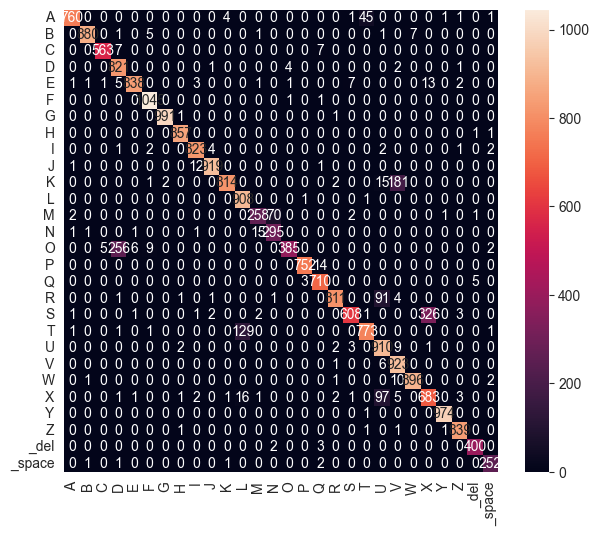

Classification Report
              precision    recall  f1-score   support

           A       0.99      0.93      0.96       813
           B       1.00      0.98      0.99       895
           C       0.99      0.98      0.98       577
           D       0.75      0.99      0.85       829
           E       0.99      0.96      0.97       873
           F       0.98      1.00      0.99      1047
           G       1.00      1.00      1.00       993
           H       0.99      1.00      1.00       859
           I       0.98      0.99      0.98       835
           J       0.99      0.98      0.99       933
           K       0.99      0.80      0.89      1015
           L       0.86      1.00      0.93       910
           M       0.93      0.77      0.84       334
           N       0.80      0.94      0.87       314
           O       0.98      0.58      0.73       663
           P       0.99      0.98      0.99       766
           Q       0.96      0.99      0.98       718
     

In [42]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

label_encoder.fit(y_train)
y_test_decoded = label_encoder.inverse_transform(y_test_encoded)
y_pred_decoded = label_encoder.inverse_transform(y_pred)

print_confusion_matrix(y_test_decoded, y_pred_decoded)

# Tensorflow-Lite

In [43]:
model.save(model_save_path, include_optimizer=False)

In [44]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\ivono\AppData\Local\Temp\tmpomwk7pio\assets


INFO:tensorflow:Assets written to: C:\Users\ivono\AppData\Local\Temp\tmpomwk7pio\assets


13448

In [45]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [46]:
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [47]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [48]:
%%time
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 0 ns


In [49]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[2.02939693e-10 1.13415267e-12 9.59561589e-07 1.83010425e-08
 2.73314375e-11 1.34904624e-07 1.12519251e-06 1.05770334e-04
 5.26288180e-10 1.26185660e-06 7.73351056e-13 3.74157523e-08
 1.79557151e-06 3.88937224e-06 5.94161476e-09 9.96482611e-01
 3.37496167e-03 5.14390919e-10 5.23748600e-10 3.47205543e-07
 3.27861849e-09 1.32134635e-12 5.61993486e-14 5.35611486e-12
 1.16570489e-10 5.43351575e-07 2.43167178e-05 2.10451753e-06]
15
